In [1]:
import numpy as np
import matplotlib.pyplot as plt

List_methode_de_flux= ["Roe","Rusanov","Godunov"]
List_condition_limite=["Neumann","Dirichlet","Periodique"]

In [ ]:

class Finite_Volume:


    def __init__(self,u0,function, derivee_de_la_function, flux_methode, film_bool =False, condition_limite = "Neumann", ghost_nodes=[0,0]):
        Valid_init = True
        self.function = function; self.derivee_de_la_function = derivee_de_la_function

        in_list =False
        for methode in List_methode_de_flux:
            if(flux_methode ==methode):  in_list =True
        if(not in_list): Valid_init = False; print("method not defined")

        in_list =False
        for condition in List_condition_limite:
            if(condition_limite ==condition): in_list =True
        if(not in_list): Valid_init = False; print("limit condition not defined")

        if(not Valid_init): f"Problème d'initialisation"

        self.flux_methode = flux_methode;   self.condition_limite = condition_limite
        self.ghost_nodes=ghost_nodes
        self.u0=u0
        self.film_bool = film_bool
    
    def sol(self,J,T,  CFL=0.95):

        dx = 1./J
        X= np.linspace(0,1,J)
        FG = np.empty_like(X) 
        FD = np.empty_like(X)
        U  = np.empty_like(X)

        Film=[]; F=[[],[]]

        U = self.u0(X)

    
        def g_godunov(u,v):
            U = np.linspace(u, v, J)
            if(u<v):    return np.min(self.function(U))
            else :      return np.max(self.function(U))

    

        g = lambda u,v: 0*u + 0*v   

        if(self.flux_methode == "Godunov"): 
            g= lambda u,v : g_godunov(u,v)
        if(self.flux_methode == "Rusanov"):
            g= lambda u,v : 0.5*(self.function(u)+self.function(v))-0.5*max(np.abs(self.derivee_de_la_function(u)), np.abs(self.derivee_de_la_function(v)))*(v-u)
        if(self.flux_methode == "Roe"):
            g= lambda u,v : (0.5*(self.function(u)+self.function(v))-0.5*np.abs(self.derivee_de_la_function(u))*(v-u))*(u==v) + (self.function(u)-self.function(v))*(v<u)

        FG = np.empty_like(X) 
        FD = np.empty_like(X)

        Film=[]; F=[[],[]]  

        t=0.; n =0; dt=0.
        while t<T and n<10000:
            #calcul de dt
            vitesse = max(abs(self.derivee_de_la_function(U)))
            if(vitesse !=0) : dt = (min(CFL * dx /(2* vitesse), T-t))
            else :            dt = CFL*dx  

            if(dt<0): dt = 10e-12; print("\n !!!! dt<0 !!! \n")

            ## Calcul du flux
            for j in range(len(X)):
                
                if(j==0):   
                    if(self.condition_limite =="Dirichlet"):    FG[j] = g(self.ghost_nodes[0],       U[j])
                    elif(self.condition_limite =="Neumann"):    FG[j] = g(U[j]+self.ghost_nodes[0],U[j])
                    elif(self.condition_limite =="Periodique"): FG[j] = g(U[-1], U[j])

                else :      FG[j]= g(U[j-1],U[j])
                
                if(j==J-1):   
                    if(self.condition_limite =="Dirichlet"):    FD[j] = g(U[j], self.ghost_nodes[1])
                    elif(self.condition_limite =="Neumann"):    FD[j] = g(U[j], U[j]+self.ghost_nodes[1])
                    elif(self.condition_limite =="Periodique"): FD[j] = g(U[j], U[0])

                else :      FD[j]= g(U[j],U[j+1]) 

                
            ## eval
            if(n%(J/5)==0):
                print(sum(U)/J)
                print(dt)
                print('----------',t,'------------')
                
            ## Calcul de la solution
            for j in range(len(X)):
                U[j] = U[j] -(dt/dx)* (FD[j]-FG[j])

            if(self.film_bool): Film.append(U.copy()); F[0].append(FD.copy()); F[1].append(FG.copy())
            n+=1; t+= dt
            

        print(t,'bloop')    

        if(self.film_bool): 
            U_xt = np.zeros((len(Film),len(U)))
            for i in range(len(Film)) : U_xt[i,:] = Film[-i]
        return U_xt


0.0
0.00095
---------- 0.0 ------------
0.0
1.3437865570448873e-05
---------- 0.012564838372665298 ------------
1.4210854715202004e-17
6.373090412370416e-06
---------- 0.013473031856030281 ------------
-4.238069238455822e-07
4.1720451823910055e-06
---------- 0.013985975727427049 ------------
-6.400026736752995e-06
3.0999715824611235e-06
---------- 0.014344830029617993 ------------
-1.8486949465807976e-05
2.4658676476426088e-06
---------- 0.014621027857654637 ------------
-3.43831836068107e-05
2.046967564765622e-06
---------- 0.01484558210126226 ------------
-5.2480668556587064e-05
1.749646532232567e-06
---------- 0.015034785106593439 ------------
-7.178959608921275e-05
1.5276989595532012e-06
---------- 0.015198262281637996 ------------
-9.1695288449539e-05
1.3556956684448047e-06
---------- 0.015342176003743177 ------------
-0.00011180480776639423
1.2184878920144353e-06
---------- 0.01547071002959407 ------------
-0.00013185915087788146
1.1064896757386475e-06
---------- 0.01558683509482

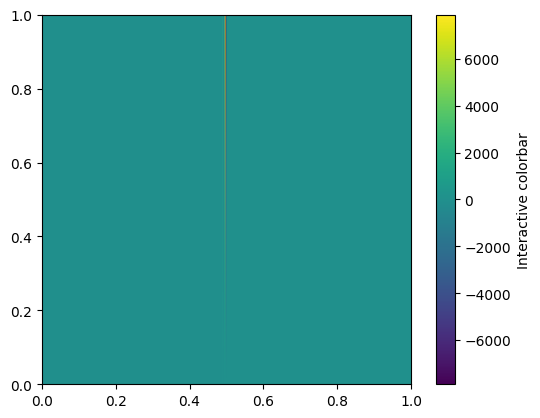

In [31]:

ul=-1.;ur=1.

U0  = lambda x: ul*(x<0.5) + ur*(x>=0.5)
#U0 = lambda x: np.sin(2*np.pi*x)
f  = lambda u: 0.5*u**2
f_p= lambda u: u  

J,T = 500,2

Fv = Finite_Volume(U0,function=f,derivee_de_la_function=f_p,flux_methode="Roe",film_bool=True, condition_limite="Neumann")

U = Fv.sol(J,T)

fig, ax = plt.subplots()
im = ax.imshow(U,extent=((0,1,0,1)))
fig.colorbar(im, ax=ax, label='Interactive colorbar')
plt.show()